In [43]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from sklearn.model_selection import GridSearchCV

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix


In [90]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import re

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use("ggplot")
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from os import path
#from PIL import image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [45]:
#import data set as dataframe and use smaller subset
#for simple modeling purposes
df=pd.read_csv("data/rotten_tomatoes_reviews.csv")
df_quick = df[:20000]
df_holdout = df[400000:]
df_quick.head()

,Freshness,Review
0,1,"Manakamana doesn't answer any questions, yet ..."
1,1,Wilfully offensive and powered by a chest-thu...
2,0,It would be difficult to imagine material mor...
3,0,Despite the gusto its star brings to the role...
4,0,If there was a good idea at the core of this ...


In [46]:
def cleaned_dframe(df, col_name = None):
    """Purpose: Take in a text based Dataframe and return a cleaned text 
    dataframe by using regex, lowercasing, stripping stop words and lemmatizing
    
    Input: Dataframe with only text column
    Output: Dataframe with only cleaned text column"""
    
    #using regexp notation to get rid of numbers in reviews
    df[col_name] = df[col_name].str.replace(r'([^a-zA-Z\s]+?)'," ")

    # 1. Create a set of documents.
    df[col_name] = df[col_name].apply(lambda x : x.lower())

    # 2. Create a set of tokenized documents.
    docs_tokenized = [word_tokenize(content) for content in df[col_name].values]
    

    # 3. Strip out stop words from each tokenized document.

    stop = set(stopwords.words('english'))
#    new_stopwords = set(["film","movie","like","feel","time","little","adject", "adds",
#                        "bestloved","agonizingly","bantamweight"])
#    stop.update(new_stopwords)
    docs_stop = [[word for word in words if word not in stop] for words in docs_tokenized]

    # Stemming / Lemmatization

    # 1. Stem using lemmatizer
    wordnet = WordNetLemmatizer()
    docs_wordnet = [[wordnet.lemmatize(word) for word in words] for words in docs_stop]
    print(docs_wordnet[:4])
    new_element =[]
    for element in docs_wordnet:
        test = " ".join(element)
        new_element.append(test) 
    new_series = pd.Series(new_element)
    col = "text"
    cleaned_df = pd.DataFrame(new_series,columns = [col])
    return cleaned_df



In [47]:
col= "Review"
cleaned_df = cleaned_dframe(df_quick.copy(), col)
cleaned_df

[['manakamana', 'answer', 'question', 'yet', 'make', 'point', 'nepal', 'like', 'rest', 'planet', 'picturesque', 'far', 'peaceable', 'kingdom'], ['wilfully', 'offensive', 'powered', 'chest', 'thumping', 'machismo', 'good', 'clean', 'fun'], ['would', 'difficult', 'imagine', 'material', 'wrong', 'spade', 'lost', 'found'], ['despite', 'gusto', 'star', 'brings', 'role', 'hard', 'ride', 'shotgun', 'hector', 'voyage', 'discovery']]


,text
0,manakamana answer question yet make point nepa...
1,wilfully offensive powered chest thumping mach...
2,would difficult imagine material wrong spade l...
3,despite gusto star brings role hard ride shotg...
4,good idea core film buried unsightly pile flat...
5,gleeson go hallmark channel route damaging int...
6,height satire dark hell patently absurd surely...
7,everyone comedian deserves better movie comedian
8,actor encourages grumpy christian embrace season
9,slight contained ineffably soulful


In [48]:
def text2num(cleaned_df, col= None, train=True, cv=None, tfidf=None):
    """Purpose: receive a df and a column for text and turn text into CountVectorized Data and tfidf
    data
    
    Input: DataFrame with string column to be numerically vectorized
    Output: A doc word count matrix and a tfidf matrix as well"""
    
    str_data = cleaned_df[col].values
    if train == True:
        X_counts = cv.fit_transform(str_data)
        X_counts_tfidf_arr = tfidf.fit_transform(X_counts).toarray()
    else:
        X_counts = cv.transform(str_data)
        X_counts_tfidf_arr = tfidf.transform(X_counts).toarray()
    return X_counts, X_counts_tfidf_arr
    
    

In [49]:
cv = CountVectorizer(lowercase=True, tokenizer=None, strip_accents= "ascii", stop_words="english",
                             analyzer='word', max_df=1.0, min_df=2,ngram_range=(1,1),
                             max_features=3000)
tfidf = TfidfTransformer(use_idf=True)


In [50]:
col2= "text"
train = True
X_counts, X_counts_tfidf_arr = text2num(cleaned_df.copy(), col2, train, cv, tfidf)
X_counts, X_counts_tfidf_arr

(<20000x3000 sparse matrix of type '<class 'numpy.int64'>'
 	with 157742 stored elements in Compressed Sparse Row format>,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [51]:
df_train = df[:20000]
df_test = df[20000:25000]
y_train = df_train.Freshness
y_test = df_test.Freshness
df_train_clean = cleaned_dframe(df_train.copy(),"Review")
df_test_clean = cleaned_dframe(df_test.copy(),"Review")
X_counts_train, X_counts_tfidf_arr_train = text2num(df_train_clean.copy(),"text",True,cv,tfidf)
X_counts_test, X_counts_tfidf_arr_test = text2num(df_test_clean.copy(),"text",False,cv,tfidf)
X_counts_test,X_counts_tfidf_arr_test
df_holdout = df[37500:45000]
y_holdout = df_holdout.Freshness
df_holdout_clean = cleaned_dframe(df_holdout.copy(),"Review")
X_counts_holdout, X_counts_tfidf_arr_holdout = text2num(df_holdout_clean.copy(),"text",False,cv,tfidf)

[['manakamana', 'answer', 'question', 'yet', 'make', 'point', 'nepal', 'like', 'rest', 'planet', 'picturesque', 'far', 'peaceable', 'kingdom'], ['wilfully', 'offensive', 'powered', 'chest', 'thumping', 'machismo', 'good', 'clean', 'fun'], ['would', 'difficult', 'imagine', 'material', 'wrong', 'spade', 'lost', 'found'], ['despite', 'gusto', 'star', 'brings', 'role', 'hard', 'ride', 'shotgun', 'hector', 'voyage', 'discovery']]
[['downsizing', 'dare', 'ask', 'human', 'ready', 'make', 'sacrifice', 'necessary', 'survival', 'preservation', 'specie', 'line'], ['film', 'even', 'perhaps', 'slow', 'pace', 'skip', 'incident', 'incident', 'precisely', 'hanging', 'movement', 'though', 'action', 'thriller', 'kaufman', 'script', 'may', 'sort', 'wonderwork'], ['problem', 'stray', 'ever', 'connect', 'audience', 'exception', 'murphy', 'back', 'story'], ['alice', 'wonderland', 'reminds', 'sleepy', 'hollow', 'empty', 'faux', 'atmospheric', 'without', 'soul']]
[['end', 'film', 'stomach', 'hurting', 'laught

In [52]:
nb_model = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

In [53]:
nb_model.fit(X_counts_tfidf_arr_train, y_train)
nb_model.score(X_counts_tfidf_arr_train,y_train), nb_model.score(X_counts_tfidf_arr_test,y_test),nb_model.score(X_counts_tfidf_arr_holdout,y_holdout)
#nb_model.predict_proba(X_counts_tfidf_arr_test)

(0.7811, 0.7324, 0.7276)

In [54]:
y_pred = nb_model.predict(X_counts_tfidf_arr_test)
type(y_pred)
#y_test = y_test.to_numpy()
type(y_test)

pandas.core.series.Series

In [93]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.73      0.73      0.73      2466
     class 1       0.74      0.73      0.74      2534

    accuracy                           0.73      5000
   macro avg       0.73      0.73      0.73      5000
weighted avg       0.73      0.73      0.73      5000



In [55]:
confusion_matrix(y_test,y_pred)

array([[1805,  661],
       [ 677, 1857]])

In [62]:
false_positives = df_test[y_pred > y_test]
false_positives.head()


,Freshness,Review
20012,0,"In spite of his low-key ambitions, debut film..."
20014,0,"A modern day noir, Josie is a film which only..."
20015,0,"Bungles who Spider-Man is, where he's coming ..."
20030,0,Thomas Harris is now hoodwinked by his creati...
20033,0,"A gothic and, for better or worse, poetic mem..."


In [67]:
false_positives.Review[20033]

' A gothic and, for better or worse, poetic memoir about a young girl and her family of Creole aristocrats.'

In [77]:
false_positives.Review[20014]

' A modern day noir, Josie is a film which only registers because of the performances from leads Sophie Turner and Dylan Mc Dermott. '

In [69]:
false_negatives = df_test[y_pred < y_test]
false_negatives.head()

,Freshness,Review
20001,1,While the film has an even and perhaps slow p...
20004,1,Believe in forgiveness comes dropping slow on...
20009,1,I expect Jessica Rothe just stenciled her nam...
20024,1,"Not a happy experience, and there are times w..."
20025,1,"The material is flawed, to be sure, but the s..."


In [75]:
false_negatives.Review[20004]

" Believe in forgiveness comes dropping slow on the characters, in the form of a snowfall that's possibly redemptive, but also cold."

In [76]:
false_negatives.Review[20025]

' The material is flawed, to be sure, but the story is less predictable than you would guess and it exudes an easy-going wit.'

In [86]:
# Problem is that i changed the stop words due to misclassifications in my 
# test set.  This could be data leakage.  Let me check on a holdout set.

df_holdout2 = df[30000:35000]
y_holdout2 = df_holdout2.Freshness
df_holdout_clean2 = cleaned_dframe(df_holdout2.copy(),"Review")
X_counts_holdout2, X_counts_tfidf_arr_holdout2 = text2num(df_holdout_clean2.copy(),"text",False,cv,tfidf)
nb_model.score(X_counts_tfidf_arr_holdout2,y_holdout2)

#It is unfortunately confirmed.  I do not have enough features or data in my
#model to get useful information.  Let's use gridsearch to arrive at a good
#small model. Let's start by going back and taking the new stop words out of 
#stop words.

0.736

In [87]:
# check out small test case on random forest classifier
clf = RandomForestClassifier(n_estimators=1000, max_features =600, max_depth=5,
                              random_state=0, min_samples_leaf=2)
clf.fit(X_counts_tfidf_arr_train, y_train)  
#print(clf.feature_importances_)
clf.score(X_counts_tfidf_arr_train,y_train), clf.score(X_counts_tfidf_arr_test,y_test)


(0.62505, 0.6212)

In [42]:
# This is really weird.  My test score varies from .72 down to .5 based on
# the sample chose.  I suspect that I do not have enough data rows or features.

In [43]:
# parameter_candidates = [
#   {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
#   {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
# ]
parameter_candidates = [{"n_estimators":[10,20,30], "max_depth":[2,3,6],
                        "min_samples_leaf":[1,2,5]}]

In [44]:
# Create a classifier object with the classifier and parameter candidates
gs = GridSearchCV(estimator=clf, param_grid=parameter_candidates, cv=5, n_jobs=-1)

# Train the classifier on data1's feature and target data
gs.fit(X_counts_tfidf_arr_train, y_train) 

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=2,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'max_dept

In [45]:
# View the accuracy score
print('Best score for data1:', gs.best_score_)

Best score for data1: 0.60776


In [46]:
# View the best parameters for the model found using grid search
print('Best n_estimators:',gs.best_estimator_.n_estimators) 
print('Best max_depth:',gs.best_estimator_.max_depth)
print('Best min_samples_leaf:',gs.best_estimator_.min_samples_leaf)

Best n_estimators: 30
Best max_depth: 6
Best min_samples_leaf: 5


In [17]:
logreg = LogisticRegression(random_state=0, solver='lbfgs',tol=.001,C=.25,max_iter=100,
                          multi_class='multinomial').fit(X_counts_tfidf_arr_train, y_train)
logreg.score(X_counts_tfidf_arr_train, y_train)

0.79856

In [18]:
logreg.score(X_counts_tfidf_arr_test,y_test)

0.698

In [61]:
logreg.coef_, logreg.intercept_

(array([[-0.3624381 ,  0.54352684,  0.61061522, ..., -0.1365129 ,
          0.47566446, -0.16723401]]), array([-0.15741201]))

In [62]:
logreg.predict_proba(X_counts_tfidf_arr_test)

array([[0.84394163, 0.15605837],
       [0.83333001, 0.16666999],
       [0.77766381, 0.22233619],
       ...,
       [0.23025242, 0.76974758],
       [0.09992779, 0.90007221],
       [0.19205354, 0.80794646]])

In [19]:
confusion_matrix(y_test,logreg.predict(X_counts_tfidf_arr_test))

array([[891, 343],
       [412, 854]])

In [97]:
parameter_candidates = [{"tol":[.01,.001,.0001], "max_iter":[100,500,1000],
                        "C":[.5,1,2]}]

In [98]:
# Create a classifier object with the classifier and parameter candidates
gs = GridSearchCV(estimator=logreg, param_grid=parameter_candidates, cv=5, n_jobs=-1)

# Train the classifier on data1's feature and target data
gs.fit(X_counts_tfidf_arr_train, y_train) 

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=0.7, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100,
                                          multi_class='multinomial',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='lbfgs',
                                          tol=0.01, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'C': [0.5, 1, 2], 'max_iter': [100, 500, 1000],
                          'tol': [0.01, 0.001, 0.0001]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [99]:
# View the accuracy score
print('Best score for data1:', gs.best_score_)

Best score for data1: 0.70584


In [100]:
# View the best parameters for the model found using grid search
print('Best tol:',gs.best_estimator_.tol) 
print('Best max_iter:',gs.best_estimator_.max_iter)
print('Best C:',gs.best_estimator_.C)

Best tol: 0.001
Best max_iter: 100
Best C: 0.5


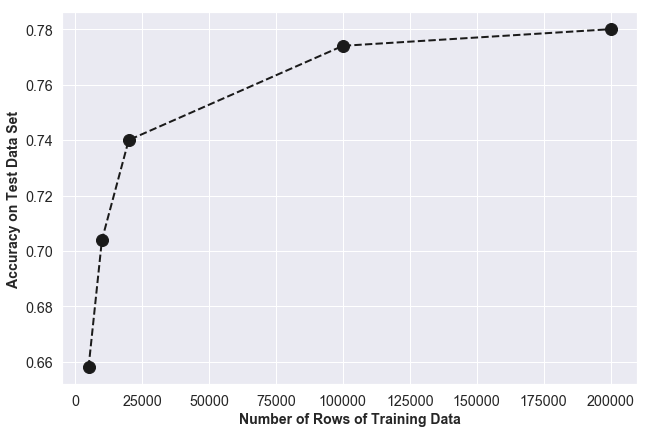

In [92]:

prob = [.658,.704,.74,.774,.78]
x = [5000,10000,20000,100000,200000]
fig, ax = plt.subplots(figsize = (9,6))
ax = plt.plot(x,prob,'ko--', linewidth=2, markersize=12)
plt.xlabel("Number of Rows of Training Data", fontsize =14, fontweight="bold")
plt.ylabel("Accuracy on Test Data Set", fontsize = 14, fontweight="bold")
#plt.title("Test Accuracy vs Training Data Size")
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig("images/accuracy2.png")
plt.show()
